# Model selection *using feed forward selection*

The model is au gaussian model with expert prior, we can take into accunt the situation and take advantage of more information a priori. It is clear that mrt station distance will have a negative correlation and same idea works for convenient store. it contributes to increase the price of the unit area. 

$Y$~$N(X\theta , \sigma^2I_d)$ with as prior :
  - $\theta$~$N(0,\sigma_b^2I_p)$ with $\theta_{MRTdistance}$ and $\theta_{convstore }$ ~$Gamma(a,b)$
  - $\sigma$~$Gamma(a,b)$

In [1]:
%matplotlib inline

from Baysian_framework import *
from Metropolis_hastings import *
from GVA import *
from Important_sampling import *

from Vizualisation_tool import *
from Model import *
from Model_torch import *

import seaborn as sns
import pandas as pd
import scipy as scp # optimization, probability densities and cumulative

In [2]:
df = pd.read_csv ('Real estate.csv')
# first drop usless variable 
data = df.drop(['No'],axis=1)

#Rename
data.rename(columns = {
                                'X1 transaction date': 'Date',
                                'X2 house age' : 'House_age',
                                'X3 distance to the nearest MRT station' : 'MRT_distance',
                                'X4 number of convenience stores' : 'Conv_store_count',
                                'X5 latitude' : 'Latitude',
                                'X6 longitude' : 'Longitude',
                                'Y house price of unit area' : 'Price_per_unit'
}, inplace = True)

X_names = [ 'Date' ,'House_age','MRT_distance','Conv_store_count','Latitude','Longitude' ]
Y_names = ['Price_per_unit' ]

data_tmp = data[data['Price_per_unit']<100]
data_no_outlier = data_tmp[data_tmp['Price_per_unit']>8]

#X= df[df.columns[1:-1]].to_numpy()

Y = (data_no_outlier['Price_per_unit']).to_numpy()

In [3]:
data_no_outlier['MRT_distance_sqrt'] = np.sqrt(data_no_outlier["MRT_distance"])

center_longitude_max = data_no_outlier['Longitude'][np.argmax(data_no_outlier['Price_per_unit'])]
center_latitude_max = data_no_outlier['Latitude'][np.argmax(data_no_outlier['Price_per_unit'])]
distance_center_vector_max = np.c_[data_no_outlier['Longitude'] - center_longitude_max,data_no_outlier['Latitude'] - center_latitude_max]
distance_vector_max = np.linalg.norm(distance_center_vector_max,axis=1)
orientation = np.arctan2(distance_center_vector_max[:,0],distance_center_vector_max[:,1])

data_no_outlier['dist_center'] = np.sqrt(distance_vector_max)
data_no_outlier['orientation'] = orientation





C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value 

100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:47<00:00, 212.06it/s]


Acceptance rate :  0.3444
            features  Coeff   std                CI    2.5   25.0   50.0  \
0          intercept  37.32  0.39  [36.535, 38.111]  36.56  37.06  37.32   
1   Conv_store_count   2.57  0.56    [1.455, 3.686]   1.50   2.19   2.54   
2  MRT_distance_sqrt  -6.63  0.60  [-7.823, -5.435]  -7.77  -7.04  -6.65   
3               Date   1.53  0.42    [0.697, 2.362]   0.68   1.26   1.53   
4          House_age  -2.90  0.39  [-3.692, -2.116]  -3.69  -3.17  -2.90   
5           Latitude   2.36  0.47    [1.414, 3.299]   1.43   2.05   2.35   
6              sigma   7.47  0.29    [6.893, 8.045]   6.92   7.28   7.47   

    75.0   97.5  
0  37.58  38.11  
1   2.97   3.69  
2  -6.22  -5.42  
3   1.81   2.34  
4  -2.64  -2.13  
5   2.65   3.31  
6   7.66   8.05  


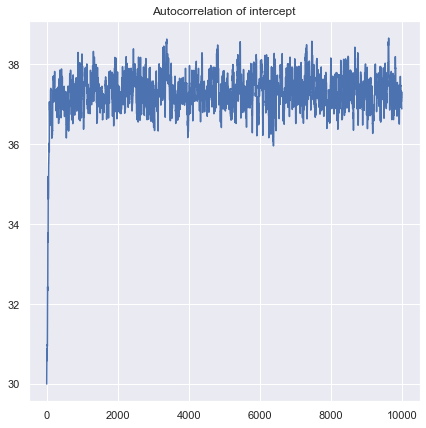

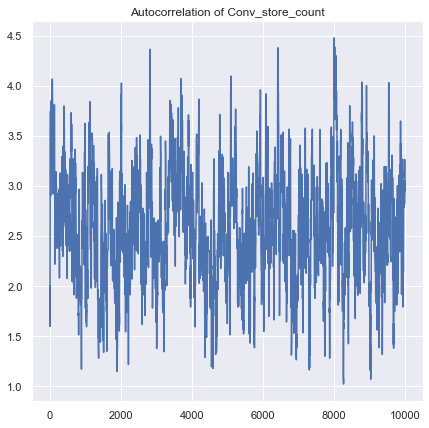

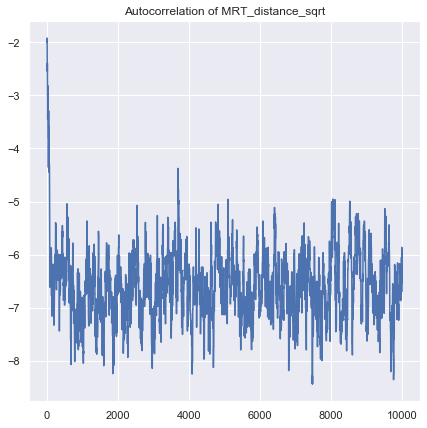

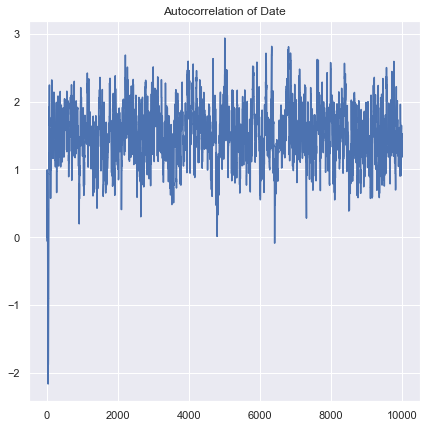

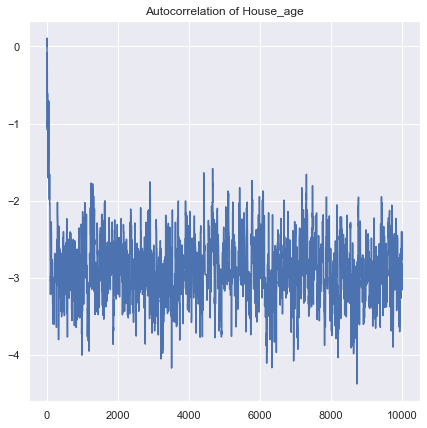

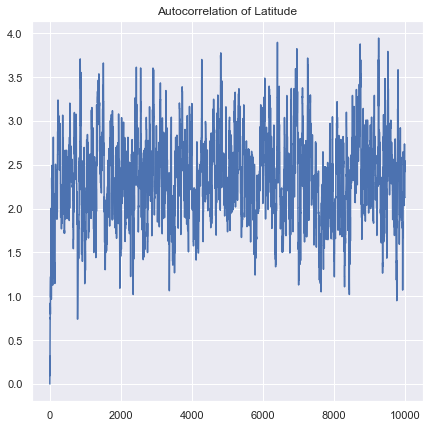

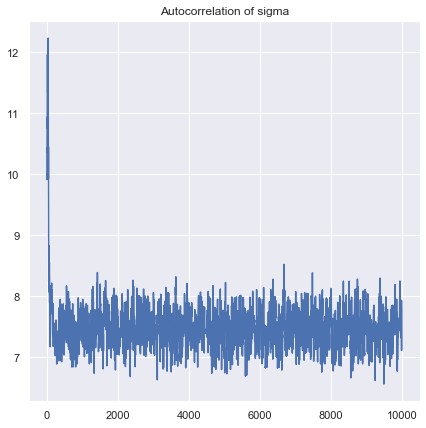

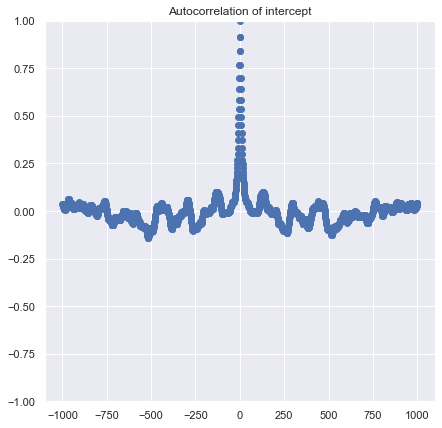

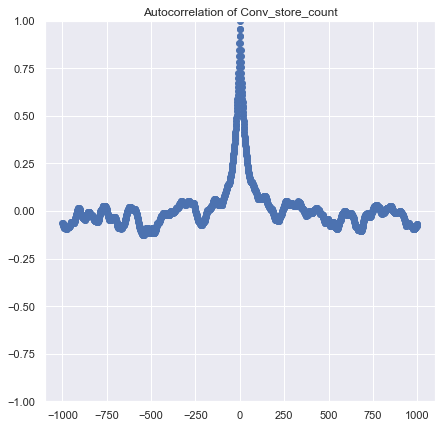

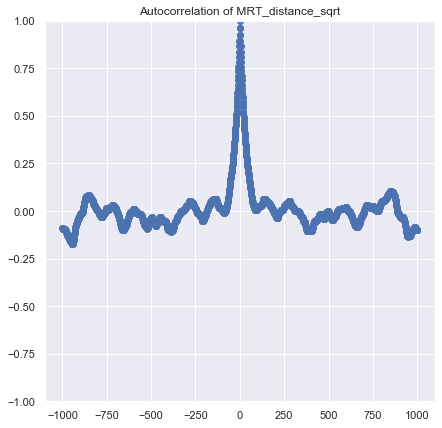

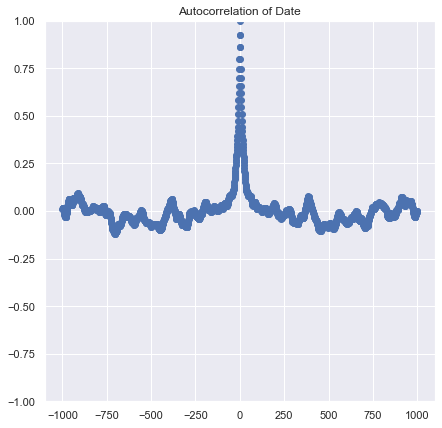

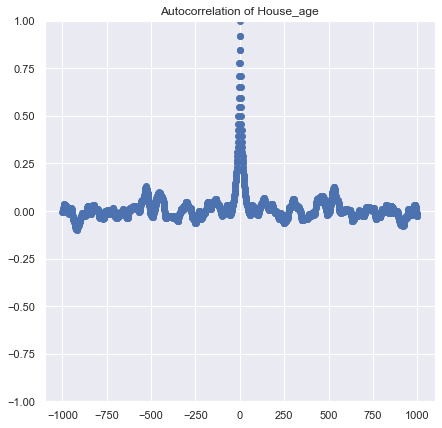

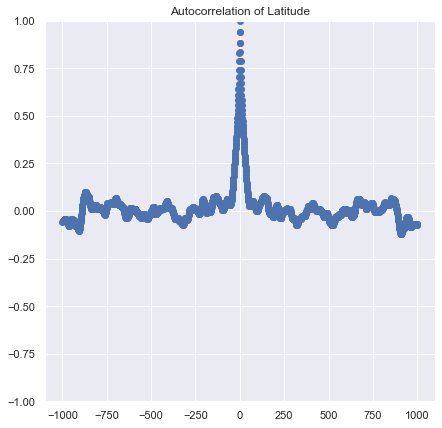

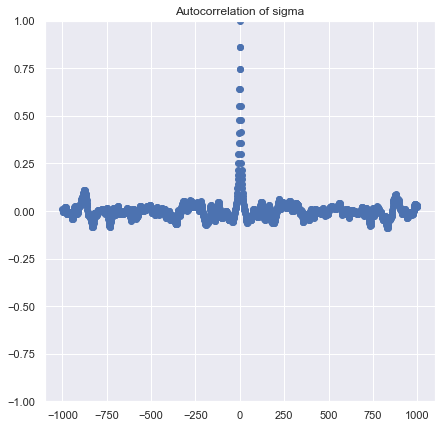

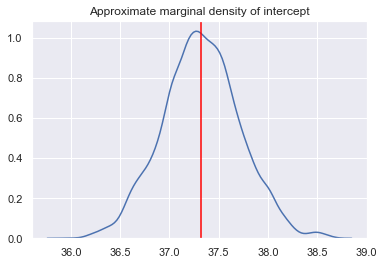

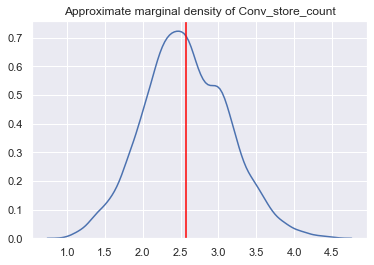

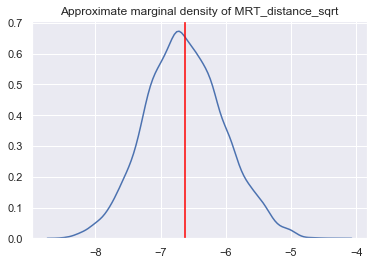

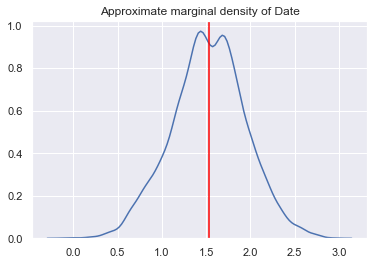

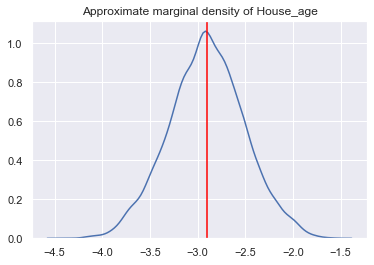

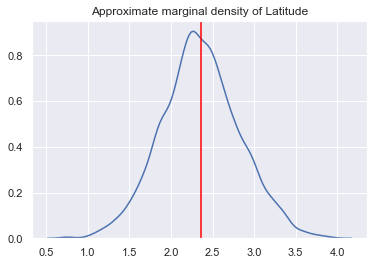

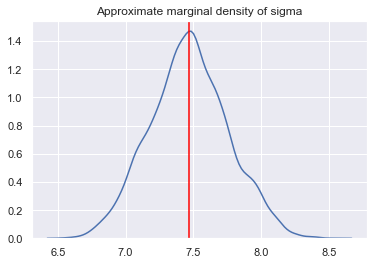

============ Fidelity summary ==================
 the mean square error is :  55.55989656332504
 MSE test is :  50.363989565976034
 PVE is  :  0.6722233274566027
 F   is  :  131.47847544262115
 p value :  1.1102230246251565e-16
 AIC is  :  2261.433001492897
 BIC is  :  2284.209347997489
 AICc is :  2261.6938710581144


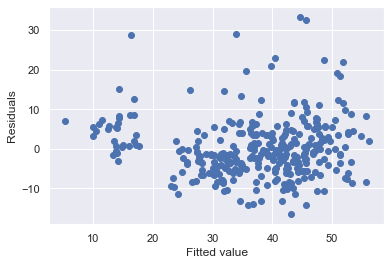

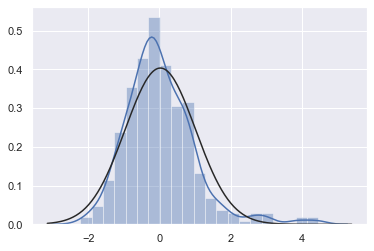

<Figure size 432x288 with 0 Axes>

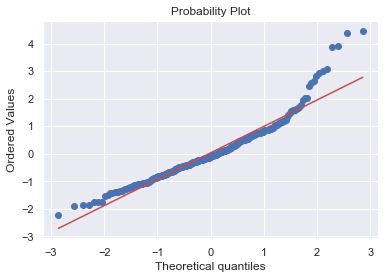

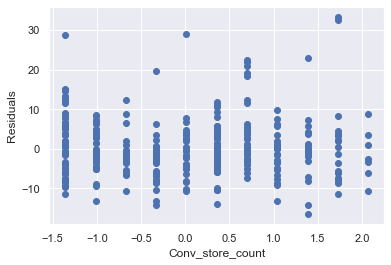

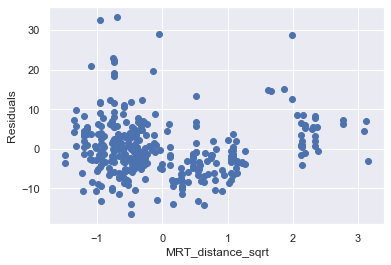

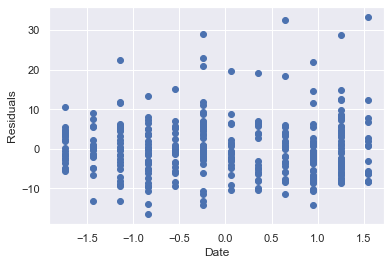

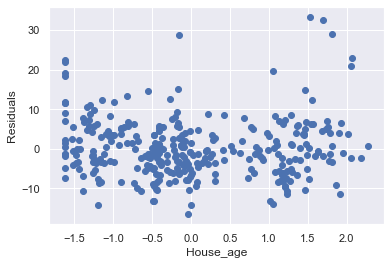

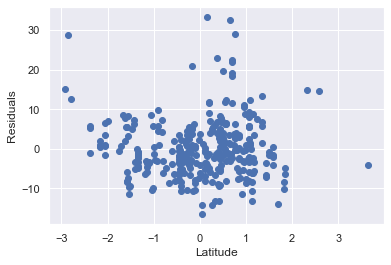

In [4]:
X_names = [ 'intercept','Conv_store_count' ,'MRT_distance_sqrt' , 'Date' ,'House_age','Latitude','sigma' ]
X = (data_no_outlier[X_names[1:-1]].dropna()).to_numpy()
Model_gaus = Bayesian_framework(len(X_names)-2,X_names,X,Y)
proba_set =  Gaussian_model_expert_prior(Model_gaus)

# Define the model
Model_gaus.set_log_joint_prior(proba_set.log_joint_prior)
Model_gaus.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
init = np.array( [30,2,-2,0,0,0,10] )
step_size = 0.3
num_samples = 10000

M_H_gaus = Metropolis_hastings(Model_gaus,init ,step_size,num_samples,mode=False)

M_H_gaus.compute_statistic()

# We see that we can select a burn in that around 200
burn_in = 500

M_H_gaus.compute_statistic(burn_in)
M_H_gaus.summary()
tool_gaus = Vizualisation_tool(Model_gaus,M_H_gaus)
tool_gaus.trace_visualization()
tool_gaus.autocorrelation_visualization()
tool_gaus.marginal_visualization()    
tool_gaus.fidelity()
tool_gaus.diagnostics()

#### Using the log Y instead 

 61%|██████████████████████████████████████████████▎                             | 6093/10000 [00:27<00:18, 212.08it/s]C:\Users\pierr\Documents\Bayesian computation\Project\Model.py:319: RuntimeWarning: invalid value encountered in log
  f = lambda b : -k_0*np.log(theta_0)-np.real(scp.special.loggamma(k_0)) + (k_0-1)*np.log(-b) + b/theta_0
100%|███████████████████████████████████████████████████████████████████████████| 10000/10000 [00:45<00:00, 218.88it/s]


Acceptance rate :  0.2566
            features  Coeff   std                CI   2.5  25.0  50.0  75.0  \
0          intercept   3.54  0.02    [3.510, 3.574]  3.52  3.54  3.54  3.55   
1   Conv_store_count   0.06  0.01    [0.032, 0.089]  0.04  0.05  0.06  0.07   
2  MRT_distance_sqrt  -0.22  0.02  [-0.247, -0.184] -0.25 -0.23 -0.22 -0.21   
3               Date   0.05  0.01    [0.023, 0.070]  0.03  0.04  0.05  0.05   
4          House_age  -0.08  0.01  [-0.098, -0.054] -0.09 -0.08 -0.08 -0.07   
5           Latitude   0.09  0.01    [0.059, 0.117]  0.06  0.08  0.09  0.10   
6              sigma   0.20  0.02    [0.158, 0.233]  0.18  0.19  0.19  0.20   

   97.5  
0  3.57  
1  0.09  
2 -0.19  
3  0.07  
4 -0.06  
5  0.11  
6  0.21  


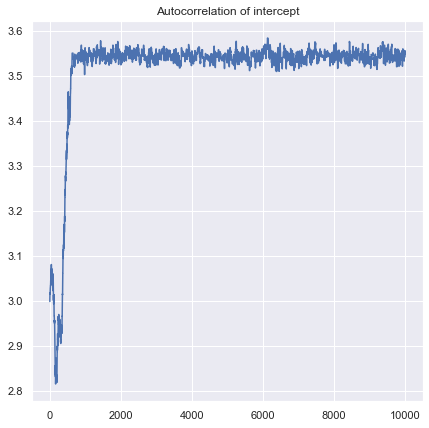

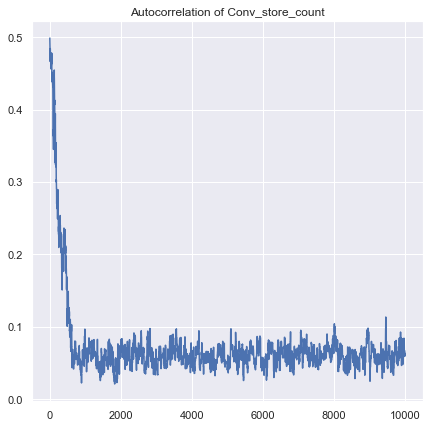

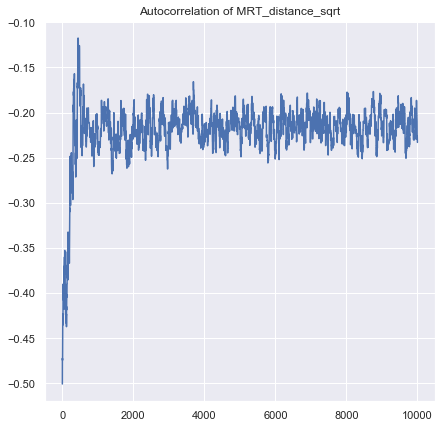

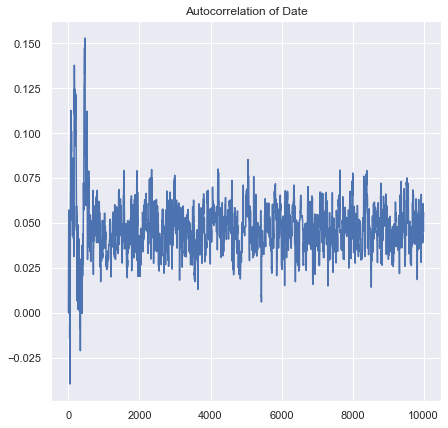

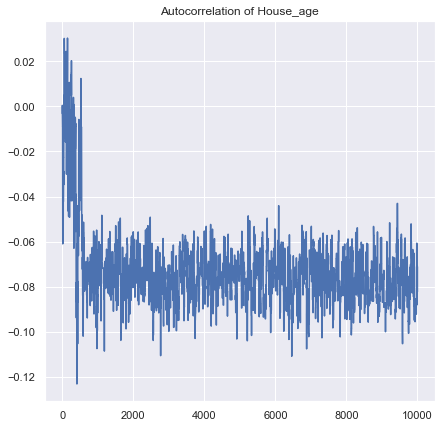

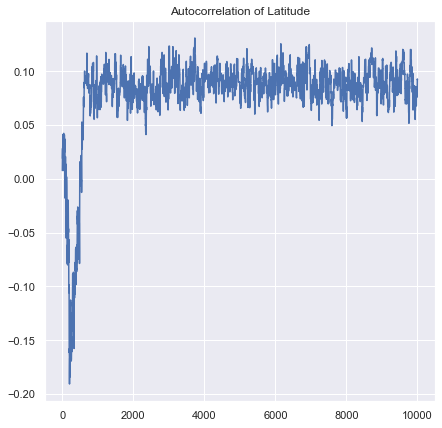

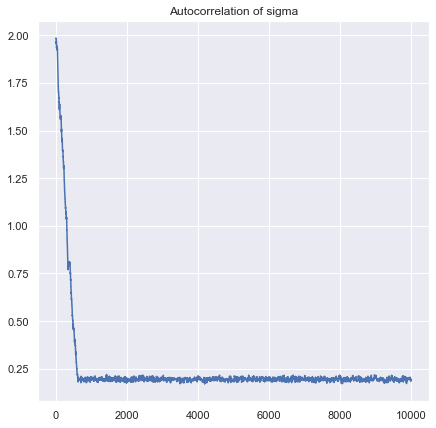

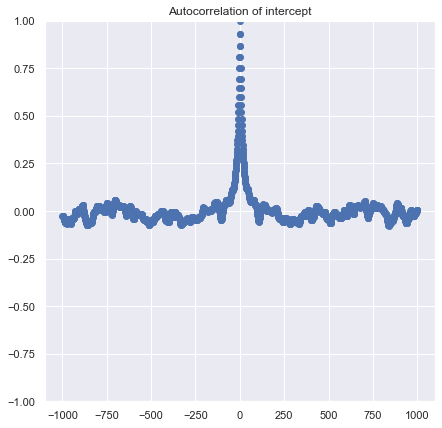

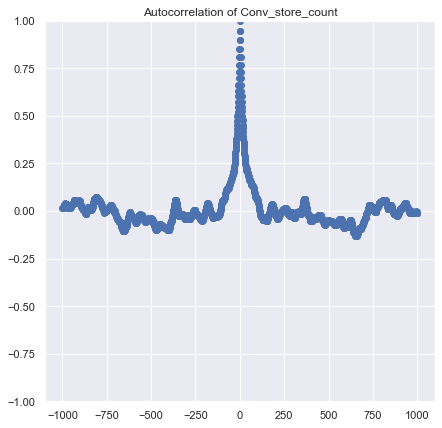

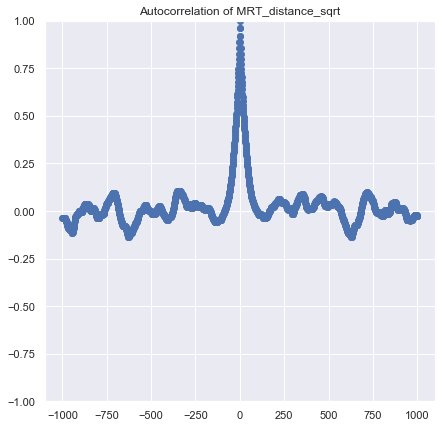

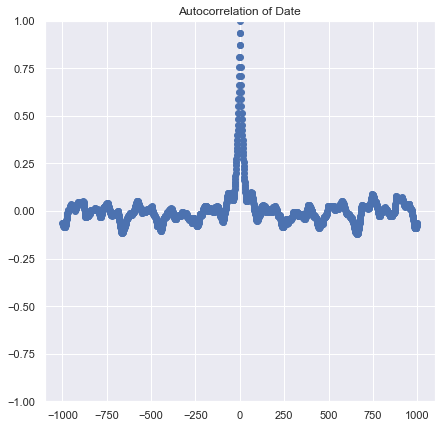

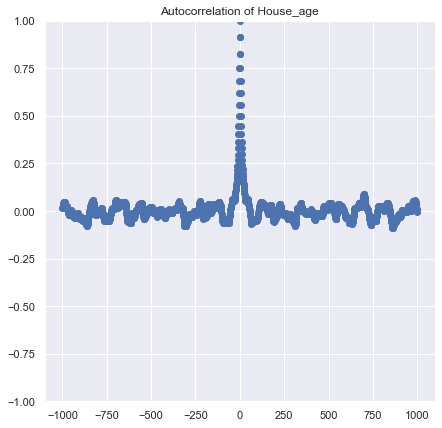

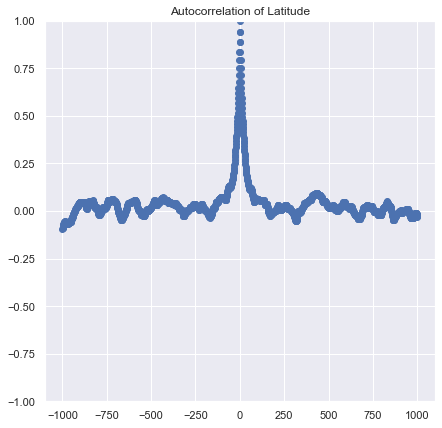

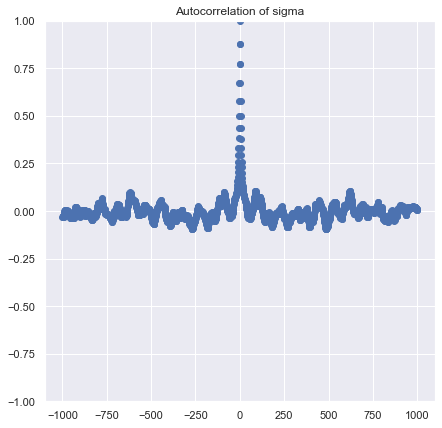

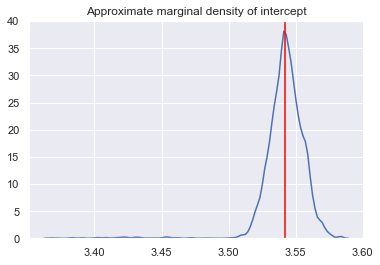

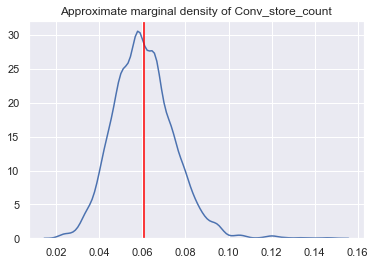

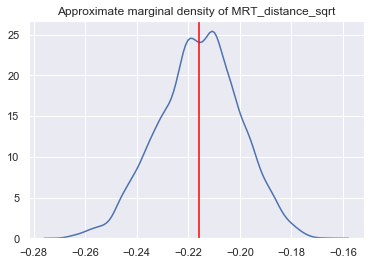

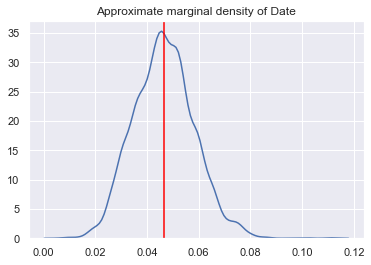

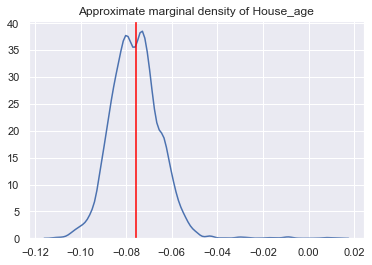

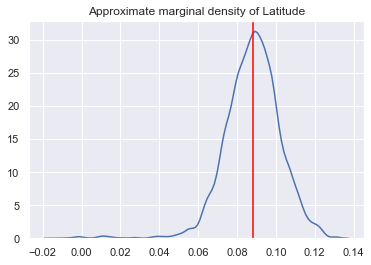

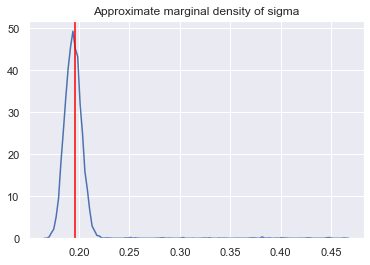

============ Fidelity summary ==================
 the mean square error is :  0.03706027231487447
 MSE test is :  45.69617289495043
 PVE is  :  0.7576282315039448
 F   is  :  192.2334838798909
 p value :  1.1102230246251565e-16
 AIC is  :  -144.09898823565726
 BIC is  :  -121.32264173106503
 AICc is :  -143.83811867043985


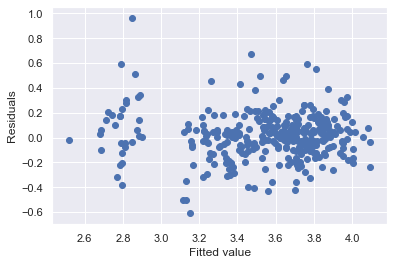

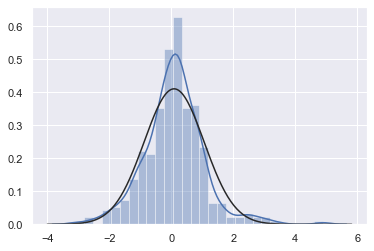

<Figure size 432x288 with 0 Axes>

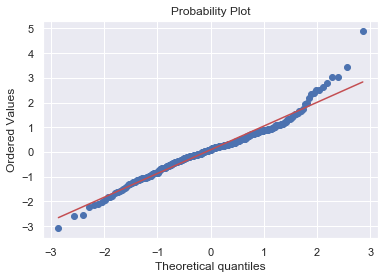

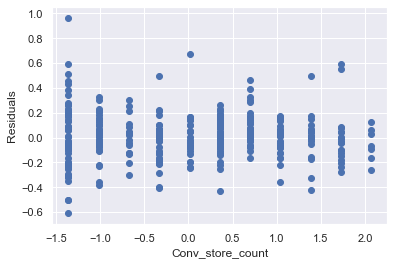

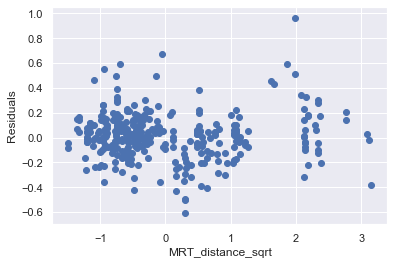

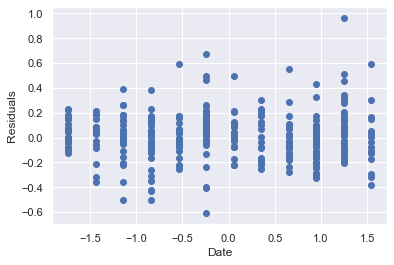

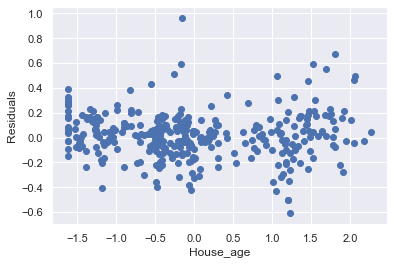

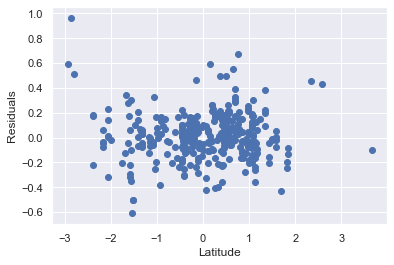

In [11]:
X_names = [ 'intercept','Conv_store_count' ,'MRT_distance_sqrt' , 'Date' ,'House_age','Latitude','sigma' ]
X = (data_no_outlier[X_names[1:-1]].dropna()).to_numpy()
Y = np.log((data_no_outlier['Price_per_unit']).to_numpy())
Model_gaus = Bayesian_framework(len(X_names)-2,X_names,X,Y, transformation_train= False, transformation_test = True)
proba_set =  Gaussian_model_expert_prior(Model_gaus)

# Define the model
Model_gaus.set_log_joint_prior(proba_set.log_joint_prior)
Model_gaus.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
init = np.array( [3,0.5,-0.5,0,0,0,2] )
step_size = 0.01
num_samples = 10000

M_H_gaus = Metropolis_hastings(Model_gaus,init ,step_size,num_samples,mode=False)

M_H_gaus.compute_statistic()

# We see that we can select a burn in that around 200
burn_in = 500

M_H_gaus.compute_statistic(burn_in)
M_H_gaus.summary()
tool_gaus = Vizualisation_tool(Model_gaus,M_H_gaus)
tool_gaus.trace_visualization()
tool_gaus.autocorrelation_visualization()
tool_gaus.marginal_visualization()    
tool_gaus.fidelity()
tool_gaus.diagnostics()

 63%|████████████████████████████████████████████████                            | 9486/15000 [00:43<00:26, 204.75it/s]C:\Users\pierr\Documents\Bayesian computation\Project\Model.py:322: RuntimeWarning: invalid value encountered in log
  f = lambda b : -k_0*np.log(theta_0)-np.real(scp.special.loggamma(k_0)) + (k_0-1)*np.log(-b) + b/theta_0
100%|███████████████████████████████████████████████████████████████████████████| 15000/15000 [01:09<00:00, 214.61it/s]


Acceptance rate :  0.2392
            features  Coeff   std                CI   2.5  25.0  50.0  75.0  \
0          intercept   3.54  0.01    [3.522, 3.564]  3.52  3.54  3.54  3.55   
1   Conv_store_count   0.06  0.01    [0.034, 0.087]  0.04  0.05  0.06  0.07   
2  MRT_distance_sqrt  -0.22  0.01  [-0.245, -0.187] -0.24 -0.23 -0.22 -0.21   
3               Date   0.05  0.01    [0.024, 0.068]  0.02  0.04  0.05  0.05   
4          House_age  -0.08  0.01  [-0.098, -0.057] -0.10 -0.08 -0.08 -0.07   
5           Latitude   0.09  0.01    [0.063, 0.113]  0.06  0.08  0.09  0.10   
6              sigma   0.19  0.01    [0.178, 0.209]  0.18  0.19  0.19  0.20   

   97.5  
0  3.56  
1  0.09  
2 -0.19  
3  0.07  
4 -0.06  
5  0.11  
6  0.21  


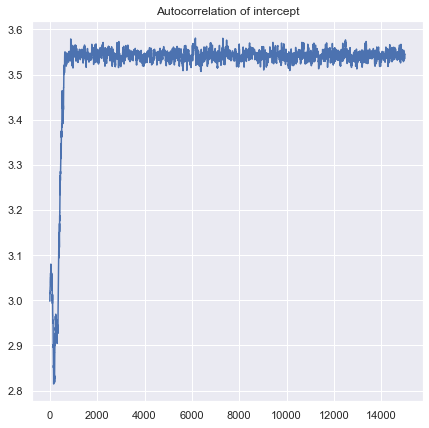

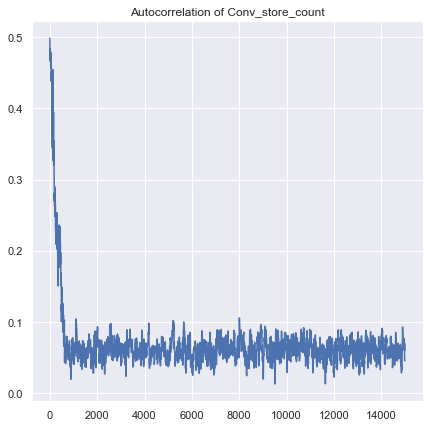

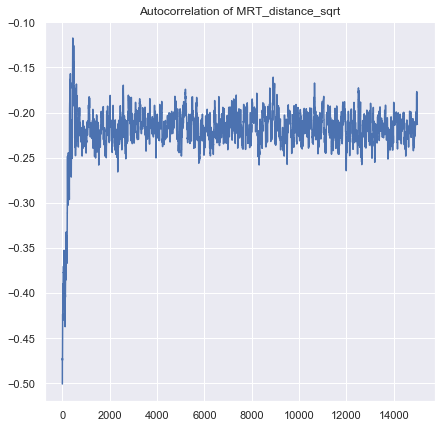

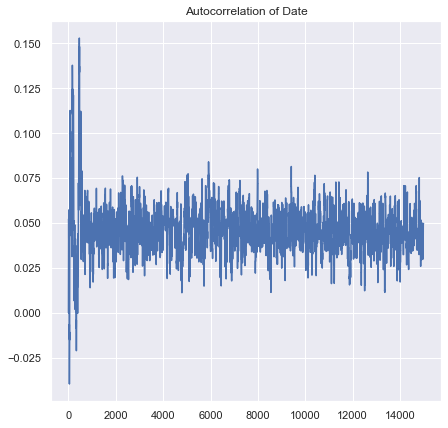

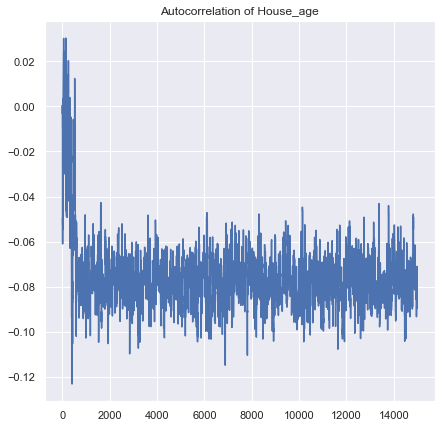

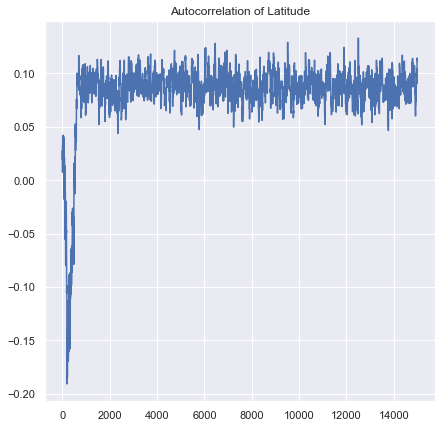

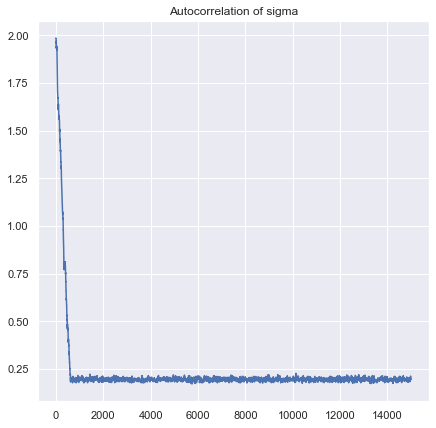

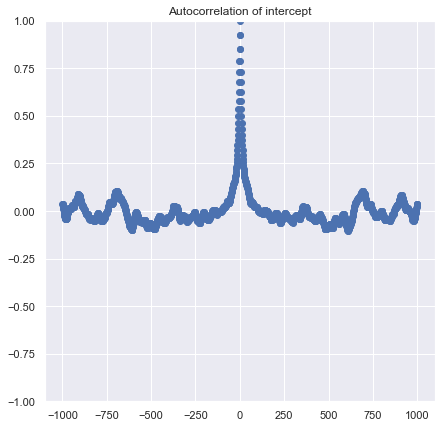

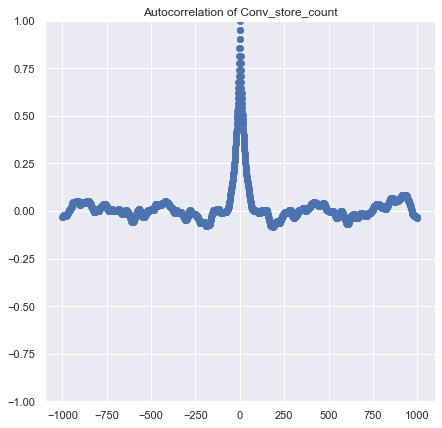

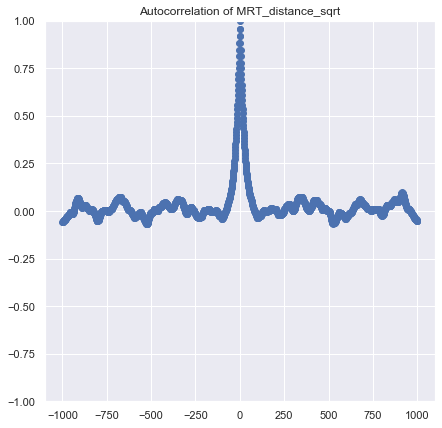

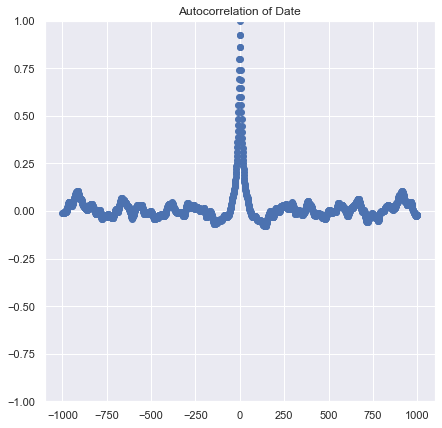

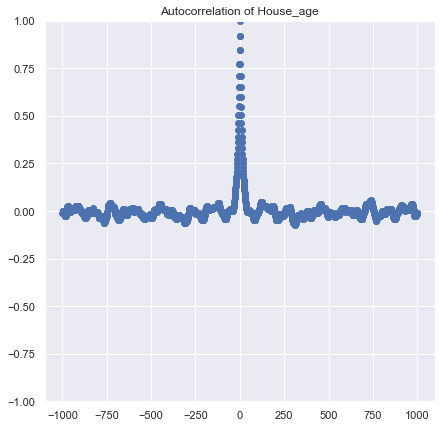

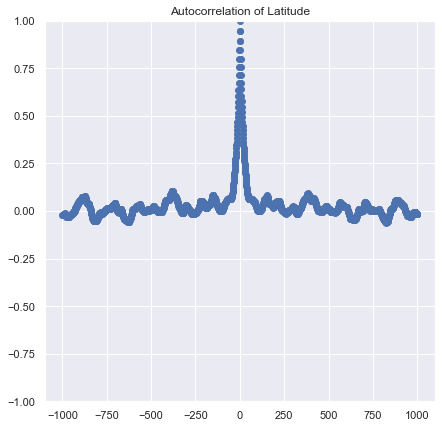

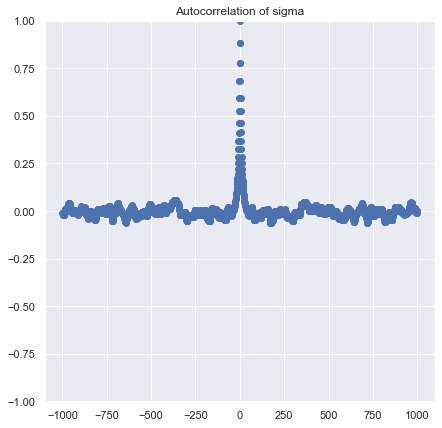

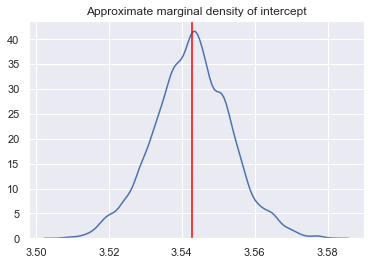

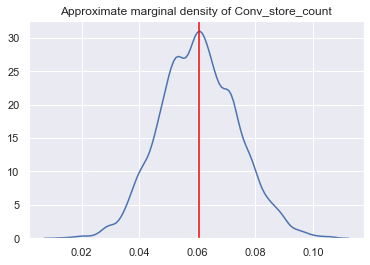

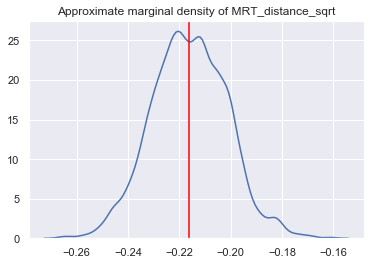

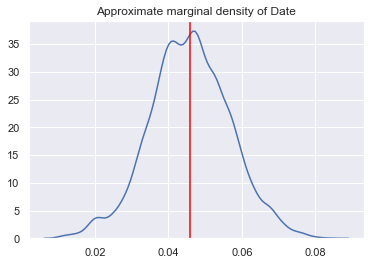

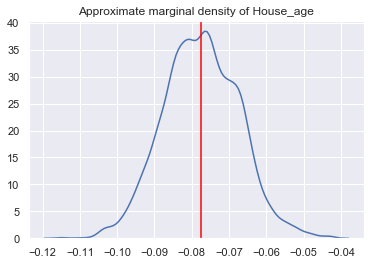

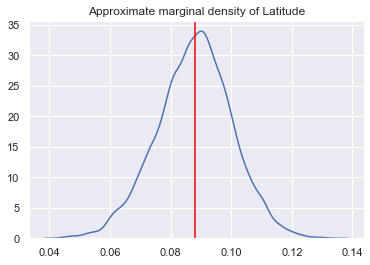

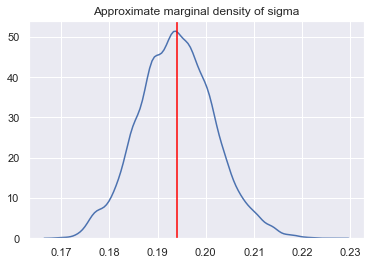

============ Fidelity summary ==================
 the mean square error is :  0.03703053470096815
 MSE test is :  45.73525133118197
 PVE is  :  0.758619742413143
 F   is  :  192.6396369525832
 p value :  1.1102230246251565e-16
 AIC is  :  -144.59397538235126
 BIC is  :  -121.81762887775903
 AICc is :  -144.33310581713386


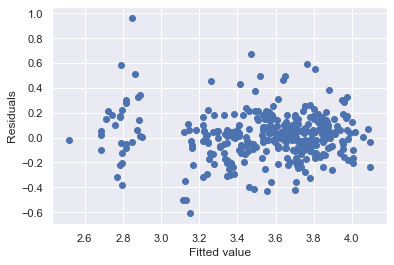

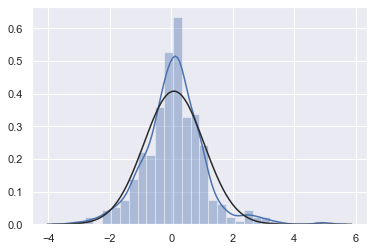

<Figure size 432x288 with 0 Axes>

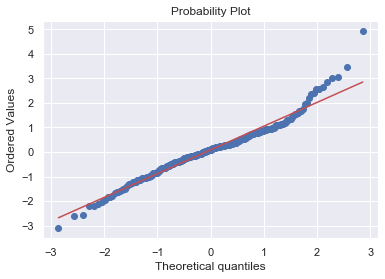

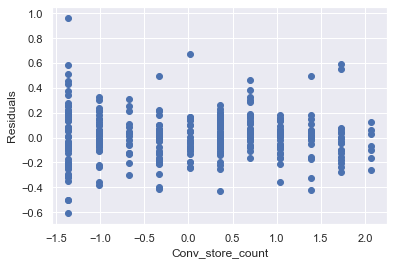

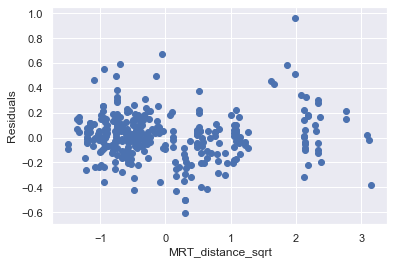

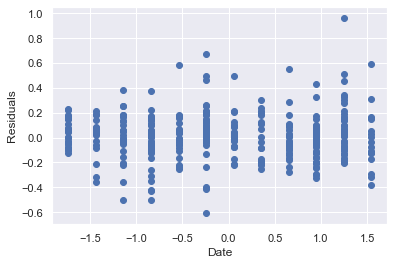

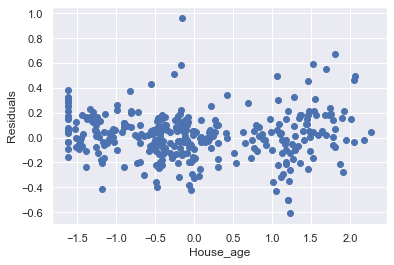

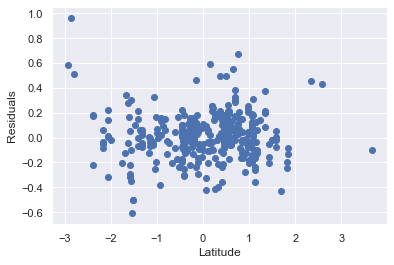

In [8]:
X_names = [ 'intercept','Conv_store_count' ,'MRT_distance_sqrt' , 'Date' ,'House_age','Latitude','sigma' ]
X = (data_no_outlier[X_names[1:-1]].dropna()).to_numpy()
Y = np.log((data_no_outlier['Price_per_unit']).to_numpy())
Model_gaus = Bayesian_framework(len(X_names)-2,X_names,X,Y, transformation_train= False, transformation_test = True)
proba_set =  Gaussian_model_expert_prior(Model_gaus , theta_0= 1)

# Define the model
Model_gaus.set_log_joint_prior(proba_set.log_joint_prior)
Model_gaus.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
init = np.array( [3,0.5,-0.5,0,0,0,2] )
step_size = 0.01
num_samples = 15000

M_H_gaus = Metropolis_hastings(Model_gaus,init ,step_size,num_samples,mode=False)

M_H_gaus.compute_statistic()

# We see that we can select a burn in that around 200
burn_in = 800

M_H_gaus.compute_statistic(burn_in)
M_H_gaus.summary()
tool_gaus = Vizualisation_tool(Model_gaus,M_H_gaus)
tool_gaus.trace_visualization()
tool_gaus.autocorrelation_visualization()
tool_gaus.marginal_visualization()    
tool_gaus.fidelity()
tool_gaus.diagnostics()

### Using gva 

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

 the loss is : tensor([1293.1045], grad_fn=<NegBackward>)
 the grad is : tensor([ -0.4690, -15.5244,  22.1672,  -2.8765,  10.5543, -16.7748,  -3.2726])
 norm of the gradient  tensor(33.8287)


  0%|▎                                                                                 | 1/300 [00:01<05:55,  1.19s/it]

tensor([37.0629,  4.0837, -4.9752,  0.3861, -1.4166,  2.2515, 10.4392])


  3%|██▍                                                                               | 9/300 [00:11<05:48,  1.20s/it]

 Norm gradient < 0.5 stop 
 GVA method takes : 11.15  s to run 
            features  Coeff   std                CI    2.5       25.0   50.0  \
0          intercept  37.32  0.46  [36.398, 38.247]  36.43  37.009998  37.32   
1   Conv_store_count   2.68  0.55    [1.571, 3.791]   1.60   2.300000   2.68   
2  MRT_distance_sqrt  -6.49  0.60  [-7.694, -5.286]  -7.66  -6.900000  -6.49   
3               Date   1.54  0.43    [0.684, 2.402]   0.70   1.250000   1.54   
4          House_age  -2.90  0.44  [-3.786, -2.015]  -3.77  -3.200000  -2.90   
5           Latitude   2.43  0.47    [1.487, 3.382]   1.51   2.110000   2.43   
6              sigma   7.51  0.33    [6.843, 8.174]   6.85   7.290000   7.51   

        75.0       97.5  
0  37.639999  38.240002  
1   3.060000   3.770000  
2  -6.080000  -5.320000  
3   1.840000   2.380000  
4  -2.600000  -2.050000  
5   2.760000   3.370000  
6   7.730000   8.150000  


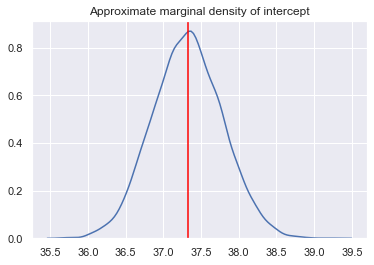

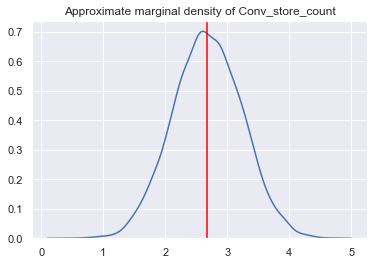

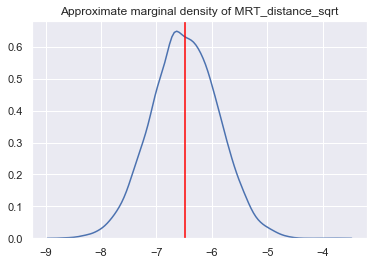

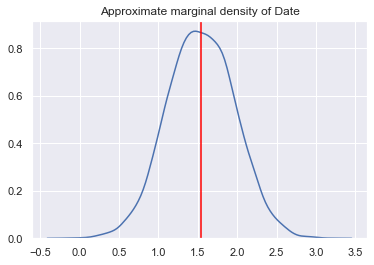

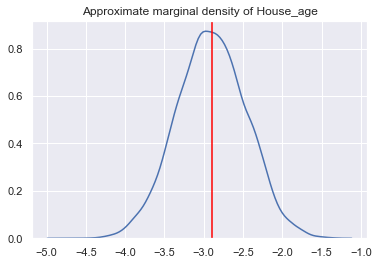

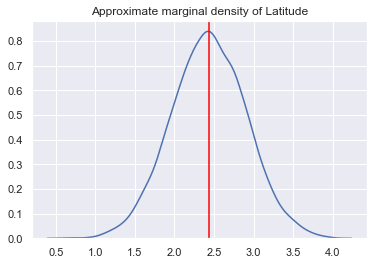

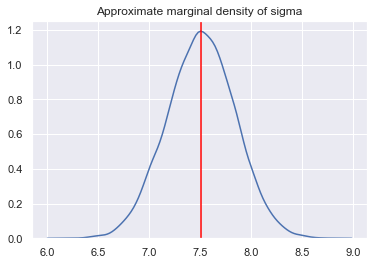

============ Fidelity summary ==================
 the mean square error is :  55.596843355600335
 MSE test is :  50.25481686007474
 PVE is  :  0.672843762508944
 F   is  :  131.51237032858148
 p value :  1.1102230246251565e-16
 AIC is  :  2261.740150213371
 BIC is  :  2284.5164967179635
 AICc is :  2262.0010197785887


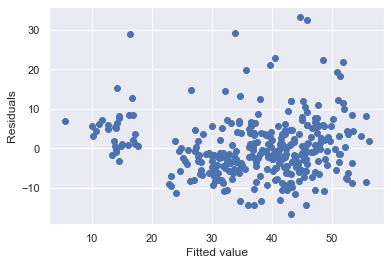

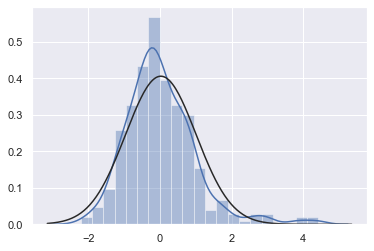

<Figure size 432x288 with 0 Axes>

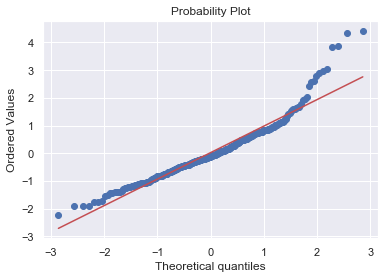

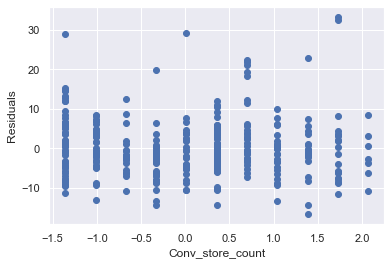

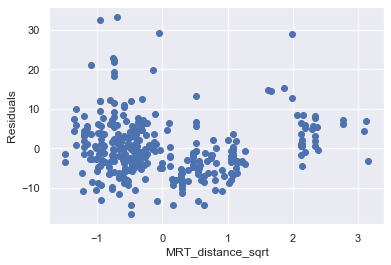

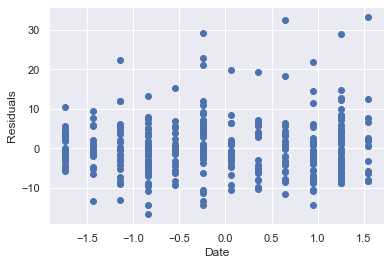

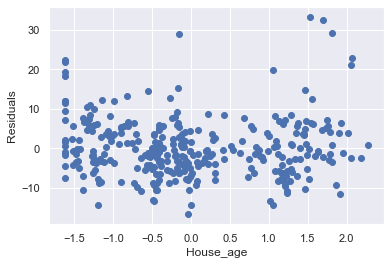

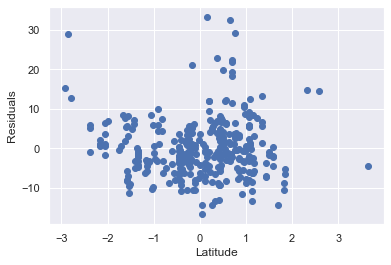

In [4]:
X_names = [ 'intercept','Conv_store_count' ,'MRT_distance_sqrt' , 'Date' ,'House_age','Latitude','sigma' ]
X = (data_no_outlier[X_names[1:-1]].dropna()).to_numpy()
Y = (data_no_outlier['Price_per_unit']).to_numpy()
Model = Bayesian_framework(len(X_names)-2,X_names,X,Y, torch_imp=True)
proba_set =  Gaussian_model_expert_prior_torch(Model , theta_0= 3.)

# Define the model
Model.set_log_joint_prior(proba_set.log_joint_prior)
Model.set_log_likelihood(proba_set.log_likelihood)
# define a sample algorithm :
gva = GVA(Model)
init_mu = torch.zeros(7)
init_mu[0]= 37
init_mu[1] = 2
init_mu[2] = -2
init_mu[-1] = 10
init_L = -2*torch.ones(7,7)
gva.compute_GVA_algo(init_mu,init_L, step_size = 0.01, show = True , line_search = True , stop_crit = 0.4)

tool = Vizualisation_tool(Model,gva)
tool.marginal_visualization()    
tool.fidelity()
tool.diagnostics()

  0%|                                                                                          | 0/300 [00:00<?, ?it/s]

 the loss is : tensor([890.8471], grad_fn=<NegBackward>)
 the grad is : tensor([  57.9945,  118.4316, -126.0338,  -32.7310,   -9.6002,   53.6035,
         -21.3709])
 norm of the gradient  tensor(194.3385)


  0%|▎                                                                                 | 1/300 [00:03<18:02,  3.62s/it]

tensor([ 2.7261,  0.4407, -0.4048,  0.1546,  0.0453, -0.2531,  2.1009])


  3%|██▋                                                                              | 10/300 [00:37<19:43,  4.08s/it]

 the loss is : tensor([231.7346], grad_fn=<NegBackward>)
 the grad is : tensor([-46.9663, -16.2959, 125.6375, -13.2556, -27.2513, -92.7596, -23.8359])
 norm of the gradient  tensor(168.3657)


  4%|██▉                                                                              | 11/300 [00:41<19:46,  4.11s/it]

tensor([ 3.5428,  0.0787, -0.1961,  0.0458, -0.0757,  0.0941,  0.2038])


  7%|█████▍                                                                           | 20/300 [01:17<18:42,  4.01s/it]

 the loss is : tensor([222.7081], grad_fn=<NegBackward>)
 the grad is : tensor([ -5.2382,   0.4224,   5.2892,  -4.5637,  -9.1030,  -3.0733, -13.6955])
 norm of the gradient  tensor(18.8758)


  7%|█████▋                                                                           | 21/300 [01:21<18:44,  4.03s/it]

tensor([ 3.5435,  0.0617, -0.2134,  0.0458, -0.0762,  0.0901,  0.1949])


  8%|██████▊                                                                          | 25/300 [01:37<18:39,  4.07s/it]

 Norm gradient < 0.5 stop 
 GVA method takes : 97.82  s to run 
            features  Coeff   std                CI   2.5  25.0  50.0  75.0  \
0          intercept   3.54  0.01    [3.520, 3.566]  3.52  3.54  3.54  3.55   
1   Conv_store_count   0.06  0.01    [0.032, 0.090]  0.03  0.05  0.06  0.07   
2  MRT_distance_sqrt  -0.21  0.02  [-0.251, -0.179] -0.25 -0.23 -0.21 -0.20   
3               Date   0.05  0.01    [0.023, 0.068]  0.02  0.04  0.05  0.05   
4          House_age  -0.08  0.01  [-0.098, -0.055] -0.10 -0.08 -0.08 -0.07   
5           Latitude   0.09  0.01    [0.062, 0.116]  0.06  0.08  0.09  0.10   
6              sigma   0.19  0.01    [0.178, 0.210]  0.18  0.19  0.19  0.20   

   97.5  
0  3.57  
1  0.09  
2 -0.18  
3  0.07  
4 -0.06  
5  0.12  
6  0.21  


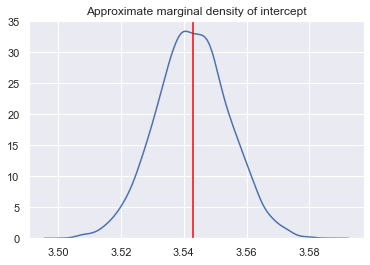

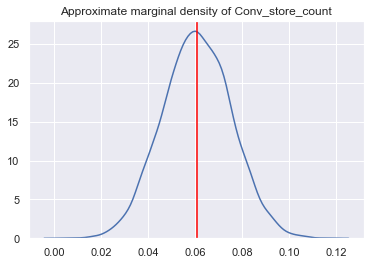

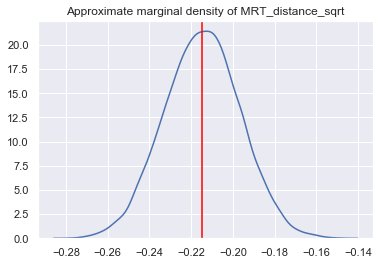

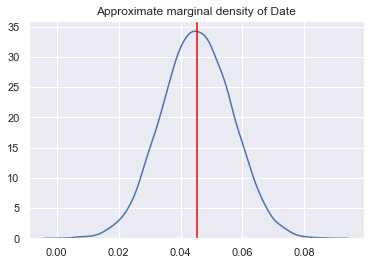

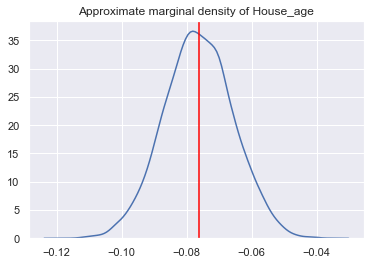

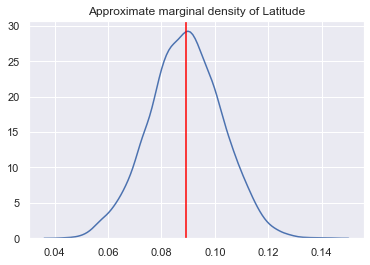

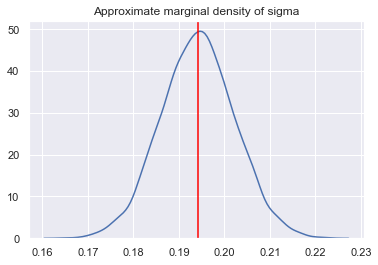

============ Fidelity summary ==================
 the mean square error is :  0.03703065581855864
 MSE test is :  45.67154693350141
 PVE is  :  0.7559802825181774
 F   is  :  191.96875944849765
 p value :  1.1102230246251565e-16
 AIC is  :  -144.5617344120385
 BIC is  :  -121.78538790744628
 AICc is :  -144.3008648468211


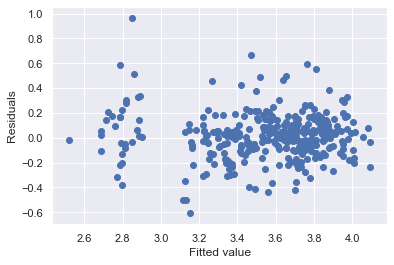

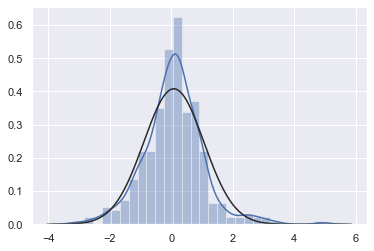

<Figure size 432x288 with 0 Axes>

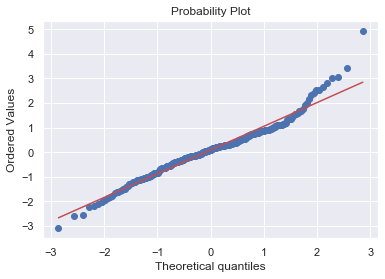

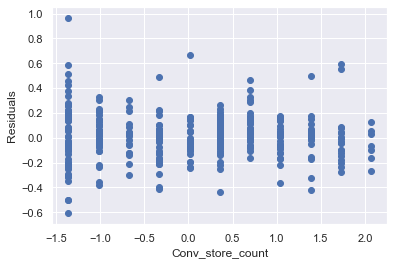

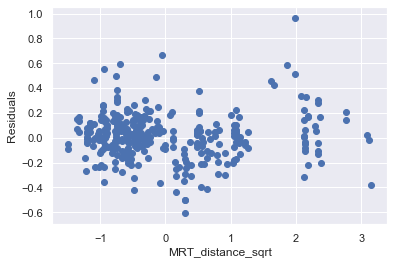

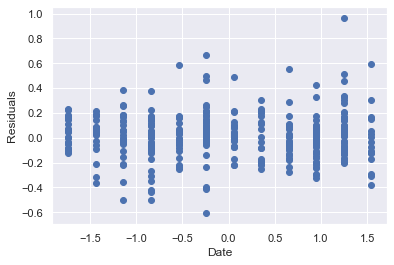

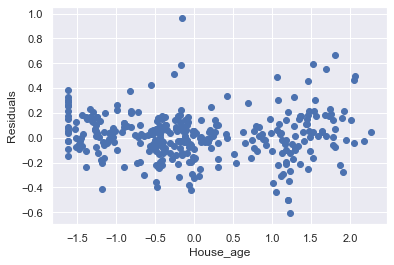

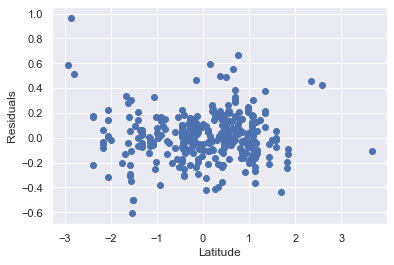

In [4]:
X_names = [ 'intercept','Conv_store_count' ,'MRT_distance_sqrt' , 'Date' ,'House_age','Latitude','sigma' ]
X = (data_no_outlier[X_names[1:-1]].dropna()).to_numpy()
Y = np.log((data_no_outlier['Price_per_unit']).to_numpy())
Model = Bayesian_framework(len(X_names)-2,X_names,X,Y, transformation_train= False, transformation_test = True , torch_imp= True)
proba_set =  Gaussian_model_expert_prior_torch(Model , theta_0= 1.)

# Define the model
Model.set_log_joint_prior(proba_set.log_joint_prior)
Model.set_log_likelihood(proba_set.log_likelihood)
# define a sample algorithm :
gva = GVA(Model)
init_mu = torch.zeros(7)
init_mu[0]= 3
init_mu[1] = 1
init_mu[2] = -1
init_mu[-1] = 2
init_L = -2*torch.ones(7,7)
gva.compute_GVA_algo(init_mu,init_L, step_size = 0.001, show = True , line_search = True , stop_crit = 10)

tool = Vizualisation_tool(Model,gva)
tool.marginal_visualization()    
tool.fidelity()
tool.diagnostics()

### Using important sampling method 

tensor([3207.7728], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([2141.1052], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1720.6776], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1565.2544], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1471.3689], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1365.1736], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1253.9367], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1251.0872], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1248.5555], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1239.8543], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1217.2336], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1185.6827], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1178.6673], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1169.9596], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1169.7811], dtype=torch.float64, grad_fn=<NegBackward>)
 Mode find out 
 It takes : 14.25  s to 

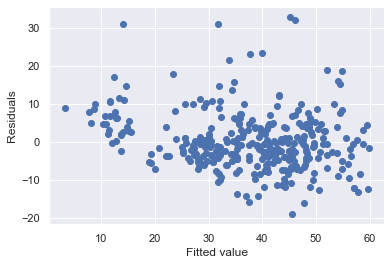

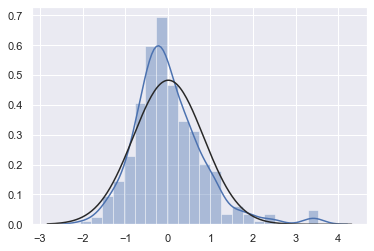

<Figure size 432x288 with 0 Axes>

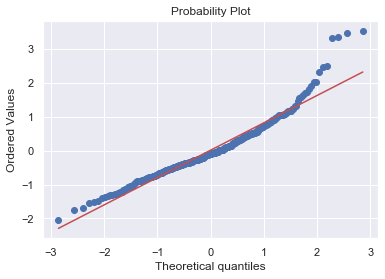

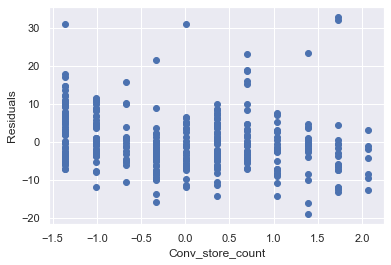

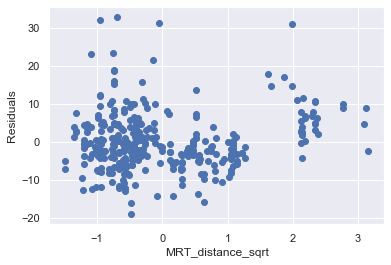

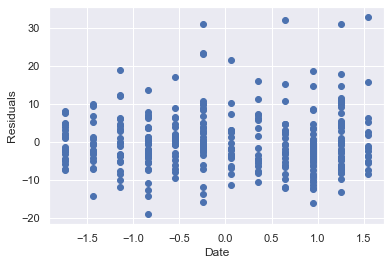

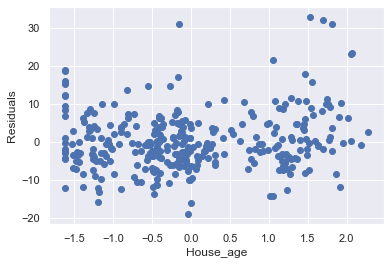

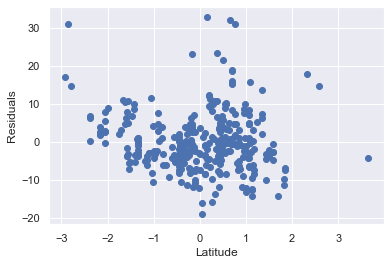

In [5]:
X_names = [ 'intercept','Conv_store_count' ,'MRT_distance_sqrt' , 'Date' ,'House_age','Latitude','sigma' ]
X = (data_no_outlier[X_names[1:-1]].dropna()).to_numpy()
Y = (data_no_outlier['Price_per_unit']).to_numpy()
Model = Bayesian_framework(len(X_names)-2,X_names,X,Y, torch_imp=True)
proba_set =  Gaussian_model_expert_prior_torch(Model , theta_0= 3.)

# Define the model
Model.set_log_joint_prior(proba_set.log_joint_prior)
Model.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
imp_s = Important_sampling(Model)
mean_proposal = imp_s.compute_mode_algo( line_search = True)
cov_mat = 0.5*np.ones(7)
proposal = st.multivariate_normal(mean = mean_proposal.view(-1).numpy() , cov = np.diag(cov_mat))
w,theta = imp_s.compute_algo(proposal , 1000000)
imp_s.compute_statistic()
imp_s.summary()

tool = Vizualisation_tool(Model,imp_s)
tool.fidelity()
tool.diagnostics()

tensor([10067.9335], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1535.0074], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1203.6391], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1105.8167], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([1023.4475], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([979.3146], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([933.8238], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([852.0544], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([760.7411], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([634.0633], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([506.1812], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([383.1481], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([339.8086], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([302.0844], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([266.0385], dtype=torch.float64, grad_fn=<NegBackward>)
tensor([229.6588], dtype=torch.float64, grad_fn=<

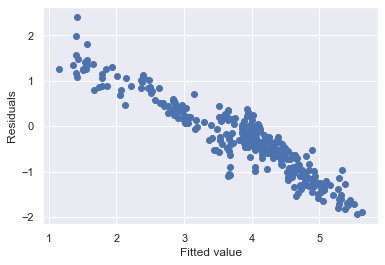

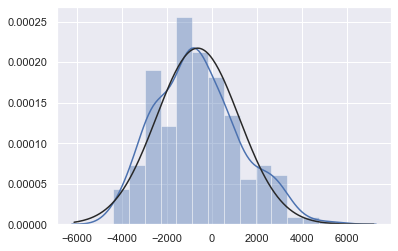

<Figure size 432x288 with 0 Axes>

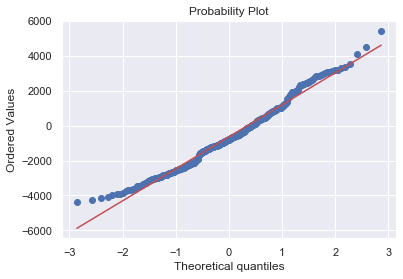

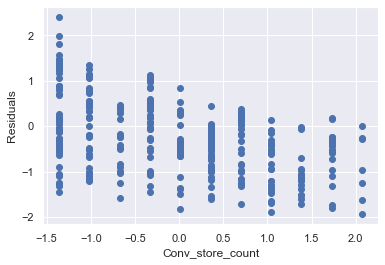

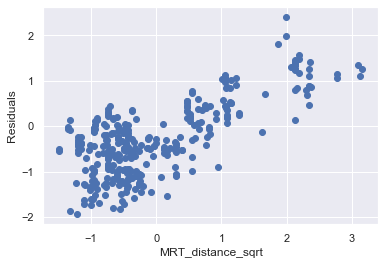

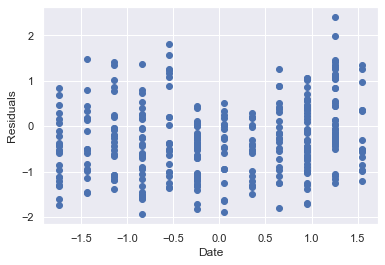

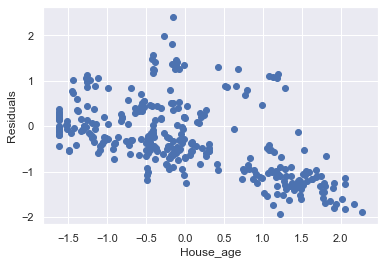

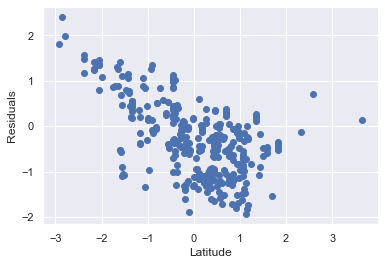

In [6]:
X_names = [ 'intercept','Conv_store_count' ,'MRT_distance_sqrt' , 'Date' ,'House_age','Latitude','sigma' ]
X = (data_no_outlier[X_names[1:-1]].dropna()).to_numpy()
Y = np.log((data_no_outlier['Price_per_unit']).to_numpy())
Model = Bayesian_framework(len(X_names)-2,X_names,X,Y, transformation_train= False, transformation_test = True , torch_imp= True)
proba_set =  Gaussian_model_expert_prior_torch(Model , theta_0= 1.)

# Define the model
Model.set_log_joint_prior(proba_set.log_joint_prior)
Model.set_log_likelihood(proba_set.log_likelihood)

# define a sample algorithm :
imp_s = Important_sampling(Model)
mean_proposal = imp_s.compute_mode_algo( line_search = True)
cov_mat = 0.5*np.ones(7)
proposal = st.multivariate_normal(mean = mean_proposal.view(-1).numpy() , cov = np.diag(cov_mat))
w,theta = imp_s.compute_algo(proposal , 1000000)
imp_s.compute_statistic()
imp_s.summary()

tool = Vizualisation_tool(Model,imp_s)
tool.fidelity()
tool.diagnostics()